- LANGUAGE: Python 3
- VERSION: v1.2
           (v1.3 - 2020-05-01 - Rabi case and cleaned Jupyter Notebook for Github)
           (v1.2 - 2018-07-21 - Jupyter Notebook)
           (v1.1 - 2018-07-06 - Python)
           (v1.0 - 2015-11-25 - Python)
- AUTHORS: 
          Tristan Benoist - tristan.benoist@irsamc.ups-tlse.fr
          Reda Chhaibi - reda.chhaibi@math.univ-toulouse.fr
- DESCRIPTION:  The aim is to study the limit of a strong noise $\gamma \rightarrow \infty$ for SDEs of the form:
$$ dX_t= b(X_t)dt + \sqrt{\gamma} \sigma(X_t)dW_t \ .$$
For precision we use Runge-Kutta approximation and refine the time discretization when X_k+1 is out of the natural bounds. The precision is thus of order h.

An important remark regarding the numerical integration scheme is the following. Let $h>0$ be time step. Effective bounds for convergence of the numerical schemes generally assume that $b$ and $\sigma$ are Lipschitz. However, in our case $\gamma$ is very large. As such one needs to be careful with the approximation quality.

We are only interested in strong approximations (trajectorial) versus weak (in law). Here are the effective orders for each numerical scheme:
- Euler: $\sqrt{\gamma h}$
- Milstein improves weak convergence. But not the strong convergence.
- Runge-Kutta or rough-path approximation: $\gamma h$.


## 1. SDE for one-dimension Belavkin

In this case, the characteristics of the SDE are given by:
$$ b(x) = -\lambda(x - p) \ ,$$
$$ \sigma(x) = x(1-x) \ .$$

In [4]:
import math

#--- Parameters and functions defining the SDE---#
eds_lambda = 1.
eds_p      = 1./2.
gamma      = 1.0e4
D          = math.sqrt(gamma)

def eds_b(x):
    """ Returns drift. """
    return -eds_lambda*(x-eds_p)

def eds_b_prime(x):
    """ Returns drift's derivative. Useful for Milstein scheme."""
    return -eds_lambda

def eds_sigma(x):
    """ Returns volatility. """
    return x*(1.-x)

def eds_sigma_prime(x):
    """ Returns volatility's derivative. Useful for Runge Kutta"""
    return 1.-2.*x

def constrains(x):
    """ Returns True if x belongs to the theoretical domain of the process. """
    return x>0 and x<1

def compute_step_Euler(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x) 
    return x + b_x*h + D*sigma_x*dW

def compute_step_Milstein(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x)
    x_euler = x + b_x*h + D*sigma_x*dW
    b_prime_x = eds_b_prime(x)
    return x_euler + 1./2.*b_x*b_prime_x*(dW**2-h)

def compute_step_RungeKutta(x,h,dW):
    b_x     = eds_b(x)
    sigma_x = eds_sigma(x) 
    sigma_prime_x = eds_sigma_prime(x)
    x_euler = x + b_x*h + D*sigma_x*dW
    return x_euler + 0.5*D*D*sigma_x*sigma_prime_x*(dW**2-h)

def compute_step(x,h,dW):
    return compute_step_RungeKutta(x,h,dW)
    
#--- Numerical integrations and stochastics---#
import numpy as np            # Matrix computation library (as a more general mathematical purpose)
import numpy.random as random # Pseudo random numbers generation sub library

def sampleBM(t,stepCount):
    """ Samples a Brownian motion up to time t, with stepCount steps"""
    h=t/float(stepCount)
    W=[0]
    W=W+random.normal(0.,np.sqrt(h),stepCount)
    return np.cumsum(W)

def sampleBB_midpoint(h):
    """ Samples midpoint in a Brownian bridge, with length h"""
    return 0.5*random.normal()*np.sqrt(h)

def compute_step_with_constrains(x,h,dW):
    new_x = compute_step(x,h,dW)
    if constrains(new_x):
        return new_x
    else:
        #Faster
        #return x
        #print("Subdivision %f -> %f"%(x, new_x))
        dP = sampleBB_midpoint(h)
        intermediate_x = compute_step_with_constrains(x,0.5*h,0.5*dW+dP)
        #print("Intermediate %f -> %f -> %f"%(x, intermediate_x, new_x))
        return compute_step_with_constrains(intermediate_x,0.5*h,0.5*dW-dP)

def SDE_integration_process(x,t,W,callback):
    """ x condition initiale, h pas de temps, W realization d'un Wiener avec des points equidistant pour le temps t. La fonction renvoie les point X_kh.
        Le processus respecte les contraintes données par la fonction du même nom.
        """
    h = t/(len(W)-1)
    percent = 0
    X = [x]
    for k in range(len(W)-1):
        x   = compute_step_with_constrains(x,h,W[k+1]-W[k])
        X.append(x)
        # Callback only when one percent is done
        # This minimizes costly communications between python kernel and notebook
        if callback is not None and percent<np.floor(100*k/len(W)):
            percent = np.ceil(100*k/len(W))
            callback(percent)
    return X

In [5]:
from ipywidgets import FloatProgress
from IPython.display import display

random.seed(3) #change to find good realization. Comment to select "random" realizations.

X_0=0.5

FinalTime=10. # final time

Npas=int(1e6) # Number of steps

print("Solving SDEs...")
print("Sampling Brownian motion...")
W=sampleBM(FinalTime,Npas)

print("Computing solution...")
X=[X_0]# Initialization of the path
x=X_0

f = FloatProgress(min=0, max=100)
display(f)
def callback(percent):
    f.value = percent

X = SDE_integration_process( X_0, FinalTime, W, callback)

print("min(min(X),1-max(X))=%e"%min(min(X),1-max(X)))
#EOF

Solving SDEs...
Sampling Brownian motion...
Computing solution...


FloatProgress(value=0.0)

min(min(X),1-max(X))=1.110717e-05


Plotting using matplotlib...


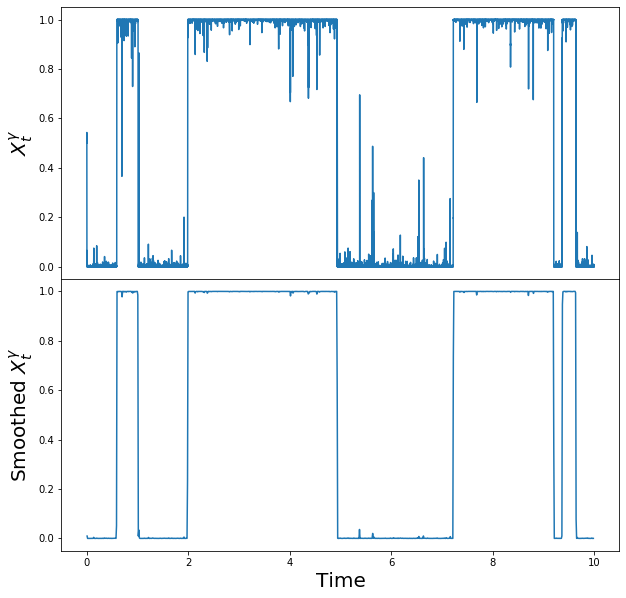

In [7]:
def smoothing(x, sampling):
    y = np.zeros(sampling, dtype=float)
    begin = 0
    mid   = np.floor(len(y)/2).astype(int)
    end   = sampling
    ratio = np.floor(len(x)/sampling).astype(int)
    for i in range(0, mid) :
        y[i] = np.mean( x[i*ratio: (i+1)*ratio] )
    for i in range(mid,end) :
        y[i] = np.mean( x[(i-1)*ratio:i*ratio] )
    return y

t = np.linspace(0, FinalTime, len(X))

import matplotlib.pyplot as plt
print("Plotting using matplotlib...")
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
axs[0].plot(t, X)
axs[0].set_ylabel("$X_t^\gamma$", fontsize=20)
axs[1].plot(smoothing(t, 1000), smoothing(X, 1000))
axs[1].set_ylabel("Smoothed $X_t^\gamma$", fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.savefig("pics/1d-Belakvin.png")
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

## 2. SDE for Rabi oscillations

In [8]:
import math
import numpy as np

#--- Parameters and functions defining the SDE---#
eds_w = 1.
gamma = 1.0e4
D     = math.sqrt(gamma)

def eds_b(theta):
    """ Returns drift. """
    return -0.25*gamma*np.sin(2*theta) + eds_w*D

def eds_b_prime(theta):
    """ Returns drift's derivative. Useful for Milstein scheme."""
    return -eds_lambda

def eds_sigma(theta):
    """ Returns volatility. """
    return -np.sin(theta)

def eds_sigma_prime(theta):
    """ Returns volatility's derivative. Useful for Runge Kutta"""
    return -np.cos(theta)

def constrains(x):
    """ Returns True if x belongs to the theoretical domain of the process. """
    return True #No constrains

In [9]:
from ipywidgets import FloatProgress
from IPython.display import display

random.seed(5) #change to find good realization. Comment to select "random" realizations.

X_0=0.5

FinalTime=5. # final time

Npas=int(1e6) # Number of steps

print("Solving SDEs...")
print("Sampling Brownian motion...")
W=sampleBM(FinalTime,Npas)

print("Computing solution...")
X=[X_0]# Initialization of the path
x=X_0

f = FloatProgress(min=0, max=100)
display(f)
def callback(percent):
    f.value = percent

X = SDE_integration_process( X_0, FinalTime, W, callback)

#EOF

Solving SDEs...
Sampling Brownian motion...
Computing solution...


FloatProgress(value=0.0)

Plotting using matplotlib...


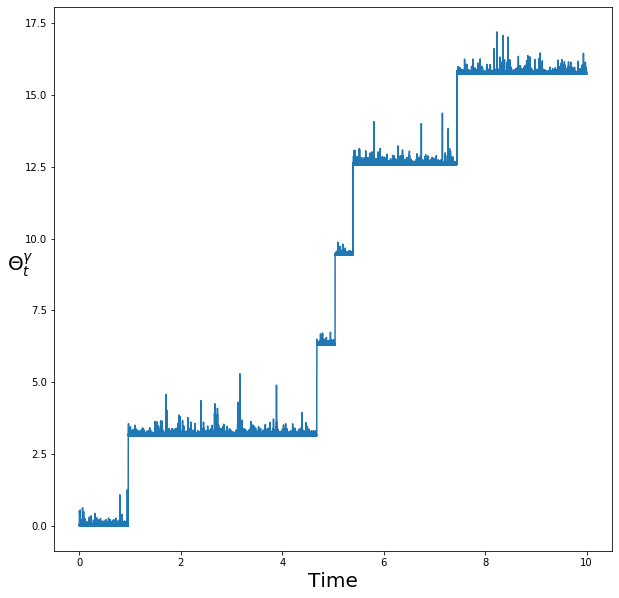

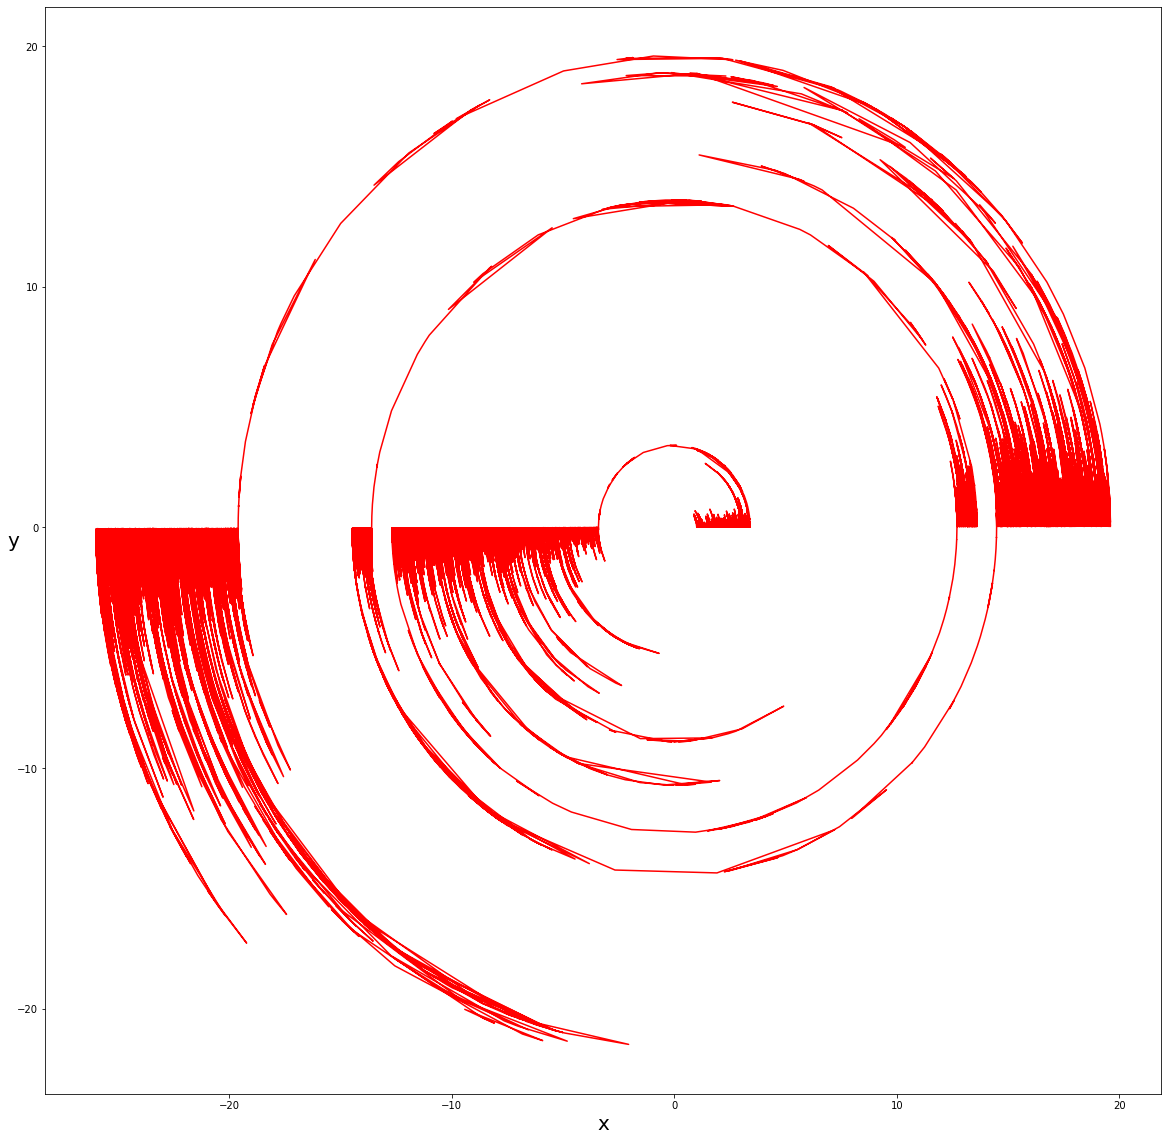

In [10]:
import matplotlib.pyplot as plt
print("Plotting using matplotlib...")
plt.figure( figsize=(10, 10) )
plt.plot(t, X)
plt.ylabel("${\Theta}_t^\gamma$", fontsize=20, rotation=0)
plt.xlabel("Time", fontsize=20)
plt.savefig("pics/1d-Rabi.png")
plt.show()

plt.rcParams["figure.figsize"] = (20,20)
scale    = 5
time_grid = np.linspace(0, FinalTime, len(X))
radial_r = 1+scale*time_grid
radial_x = radial_r*np.cos(X)
radial_y = radial_r*np.sin(X)
#Plot of curve
plt.plot(radial_x, radial_y, 'r')
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20, rotation=0)
#Plot of dashed lines for time
#radial_r = 1+scale*np.linspace(0, FinalTime, 4)
#for r in radial_r:
#    radial_x = r*np.cos( np.linspace(0, 2*np.pi, 256) )
#    radial_y = r*np.sin( np.linspace(0, 2*np.pi, 256) )
#    plt.plot( radial_x, radial_y, 'k--' )
plt.savefig("pics/1d-RabiRadial.png")
plt.show()